In [ ]:
!git clone https://github.com/NSTiwari/Fine-tune-IDEFICS-Vision-Language-Model

Cloning into 'Fine-tune-IDEFICS-Vision-Language-Model'...
remote: Enumerating objects: 828, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 828 (delta 41), reused 108 (delta 41), pack-reused 699
Receiving objects: 100% (828/828), 150.24 MiB | 35.38 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Updating files: 100% (1207/1207), done.


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.gi
!pip install -q accelerate datasets peft bitsandbytes

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.gi /tmp/pip-req-build-vga_cb7q did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.gi /tmp/pip-req-build-vga_cb7q did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

ds1 = load_dataset("Mozilla/flickr30k-transformed-captions")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
ds1

DatasetDict({
    test: Dataset({
        features: ['image', 'alt_text', 'sentids', 'split', 'img_id', 'filename', 'original_alt_text'],
        num_rows: 31014
    })
})

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("Mozilla/flickr30k-transformed-captions", split="test")
eval_dataset = load_dataset("Mozilla/flickr30k-transformed-captions", split="test")

train_dataset = train_dataset.select(range(1000))
eval_dataset = eval_dataset.select(range(200))

Generating test split:   0%|          | 0/31014 [00:00<?, ? examples/s]

In [ ]:
train_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
 'alt_text': ['Two people with shaggy hair look at their hands while hanging out in the yard.'],
 'sentids': ['0', '1', '2', '3', '4'],
 'split': 'train',
 'img_id': '0',
 'filename': '1000092795.jpg',
 'original_alt_text': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.',
  'Two young, White males are outside near many bushes.',
  'Two men in green shirts are standing in a yard.',
  'A man in a blue shirt standing in a garden.',
  'Two friends enjoy time spent together.']}

In [ ]:
train_dataset

Dataset({
    features: ['image', 'alt_text', 'sentids', 'split', 'img_id', 'filename', 'original_alt_text'],
    num_rows: 1000
})

In [ ]:
train_dataset[0]['alt_text']

['Two people with shaggy hair look at their hands while hanging out in the yard.']

In [ ]:
import torch
from peft import LoraConfig
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics2ForConditionalGeneration

DEVICE = "cuda:0"
USE_LORA = False
USE_QLORA = True

processor = AutoProcessor.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    do_image_splitting=False
)

processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        quantization_config=bnb_config if USE_QLORA else None,
    )
    model.add_adapter(lora_config)
    model.enable_adapters()
else:
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2",
    ).to(DEVICE)

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
import random
from PIL import Image

class MyDataCollator:
    def __init__(self, processor):
        self.processor = processor
        self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")
        ]

    def __call__(self, examples):
        texts = []
        images = []
        for example in examples:
            image = example["image"]
            question = random.choice(example["alt_text"])
            answer = random.choice(example["original_alt_text"])
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "Answer precisely based on the image provided in less than 50 words."},
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]


            text = self.processor.apply_chat_template(messages, add_generation_prompt=False)
            texts.append(text.strip())
            images.append([image])

        batch = self.processor(text=texts, images=images, return_tensors="pt", padding=True)

        labels = batch["input_ids"].clone()
        labels[labels == self.processor.tokenizer.pad_token_id] = self.image_token_id
        batch["labels"] = labels

        return batch

data_collator = MyDataCollator(processor)


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = "IDEFICS_DocVQA_1",
    learning_rate = 2e-4,
    fp16 = True,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 4,
    dataloader_pin_memory = False,
    save_total_limit = 3,
    evaluation_strategy ="steps",
    save_strategy = "steps",
    eval_steps = 10,
    save_steps = 25,
    max_steps = 25,
    logging_steps = 5,
    remove_unused_columns = False,
    push_to_hub=False,
    label_names = ["labels"],
    load_best_model_at_end = False,
    report_to = "none",
    optim = "paged_adamw_8bit",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
train_dataset

Dataset({
    features: ['image', 'alt_text', 'sentids', 'split', 'img_id', 'filename', 'original_alt_text'],
    num_rows: 1000
})

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
train_dataset

Dataset({
    features: ['image', 'alt_text', 'sentids', 'split', 'img_id', 'filename', 'original_alt_text'],
    num_rows: 1000
})

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
10,1.417900,1.448349
20,0.480900,0.455404


/usr/local/lib/python3.10/dist-packages/transformers/integrations/peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


TrainOutput(global_step=25, training_loss=1.9154475402832032, metrics={'train_runtime': 307.5306, 'train_samples_per_second': 0.325, 'train_steps_per_second': 0.081, 'total_flos': 628168136080320.0, 'train_loss': 1.9154475402832032, 'epoch': 0.1})

In [ ]:
test_example=eval_dataset

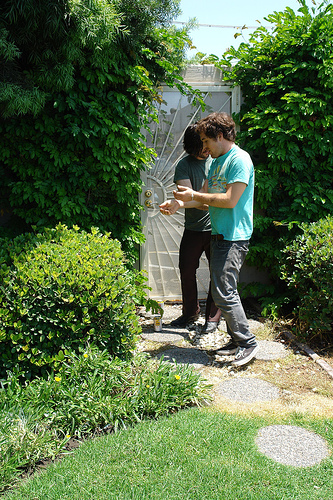

In [ ]:
test_example[0]['image']

In [ ]:
test_example

Dataset({
    features: ['image', 'alt_text', 'sentids', 'split', 'img_id', 'filename', 'original_alt_text'],
    num_rows: 200
})

In [ ]:
import torch
from tqdm import tqdm

def evaluate_model_single_example(model, processor, example, max_new_tokens=64):
    model.eval()

    image = Image.open("/content/Screenshot 2024-07-31 124507.png")
    query = "what is the total of the bill and what percent of tax was applied?"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Answer in detail related to the image provided."},
                {"type": "image"},
                {"type": "text", "text": query}
            ]
        }
    ]

    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True)

    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)

    generated_text = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)[0]
    return generated_text


example = Image.open("/content/Screenshot 2024-07-31 124507.png")
import time
start=time.time()
generated_response = evaluate_model_single_example(model, processor, example)
end = time.time()
print("time taken",end-start)
print(generated_response)


time taken 6.735251426696777
The total of the bill was $61.27 and tax was applied at 20%.


In [ ]:
eval_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
 'alt_text': ['Two people with shaggy hair look at their hands while hanging out in the yard.'],
 'sentids': ['0', '1', '2', '3', '4'],
 'split': 'train',
 'img_id': '0',
 'filename': '1000092795.jpg',
 'original_alt_text': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.',
  'Two young, White males are outside near many bushes.',
  'Two men in green shirts are standing in a yard.',
  'A man in a blue shirt standing in a garden.',
  'Two friends enjoy time spent together.']}

In [ ]:
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
 'alt_text': ['Two people with shaggy hair look at their hands while hanging out in the yard.'],
 'sentids': ['0', '1', '2', '3', '4'],
 'split': 'train',
 'img_id': '0',
 'filename': '1000092795.jpg',
 'original_alt_text': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.',
  'Two young, White males are outside near many bushes.',
  'Two men in green shirts are standing in a yard.',
  'A man in a blue shirt standing in a garden.',
  'Two friends enjoy time spent together.']}

In [ ]:
import torch
from tqdm import tqdm

def evaluate_model_single_example(model, processor, example, max_new_tokens=64):
    model.eval()

    image = example["image"]
    query = "how many people are there ?"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Answer briefly."},
                {"type": "image"},
                {"type": "text", "text": query}
            ]
        }
    ]

    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True)

    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)

    generated_text = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)[0]
    return generated_text


example = eval_dataset[3]
generated_response = evaluate_model_single_example(model, processor, example)
print(generated_response)


One person is on a ladder cleaning windows.


In [ ]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForSeq2SeqLM

def load_image(image_path):

    return Image.open(image_path).convert("RGB")
def evaluate_model_single_example(model, processor, image, query, max_new_tokens=64):
    model.eval()

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Answer in detail."},
                {"type": "image"},
                {"type": "text", "text": query}
            ]
        }
    ]

    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True)

    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=True, top_k=50, top_p=0.95)

    generated_text = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)[0]
    return generated_text



# Load your own image
image_path = '/content/graph-wiki_ver_1.png'
image = load_image(image_path)
query="how many animals are there?"

generated_response = evaluate_model_single_example(model, processor, image,query)
print(generated_response)


Four animals, each with their own color.


In [ ]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForSeq2SeqLM

def load_image(image_path):
    return Image.open(image_path).convert("RGB")
def evaluate_model_single_example(model, processor, image, query, max_new_tokens=64):
    model.eval()

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Answer briefly."},
                {"type": "image"},
                {"type": "text", "text": query}
            ]
        }
    ]

    text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True)

    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=True, top_k=50, top_p=0.95)

    generated_text = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)[0]
    return generated_text



# Load your own image
image_path = '/content/graph-wiki_ver_1.png'
image = load_image(image_path)
query="how many animals are there and list the animals?"

generated_response = evaluate_model_single_example(model, processor, image,query)
print(generated_response)


There are 4 animals.


In [ ]:
image_path = '/content/graph-wiki_ver_1.png'
image = load_image(image_path)
query="how many hamsters are there?"

generated_response = evaluate_model_single_example(model, processor, image,query)
print(generated_response)

Two hamsters.


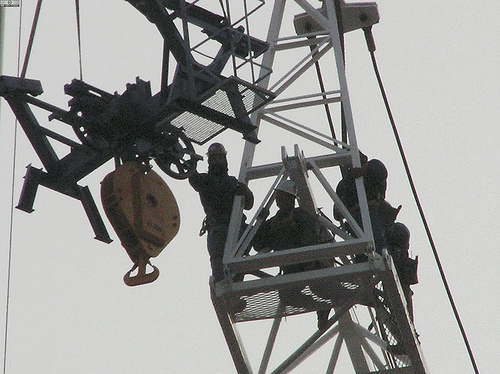

In [ ]:
eval_dataset[1]['image']

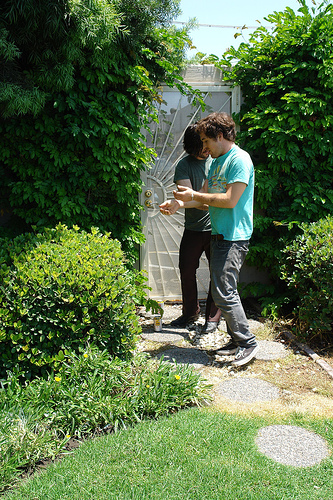

In [ ]:
eval_dataset[0]['image']

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import whoami
from pathlib import Path

# Output directory.
output_dir = "IDEFICS_DocVQA_1"
repo_name = "IDEFICS2-DocVQA-fine-tuned"
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{repo_name}"


In [ ]:
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id


upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="Pushed the IDEFICS2 fine-tuned model.",
    ignore_patterns=["step_*", "epoch_*"],
)

adapter_model.safetensors:   0%|          | 0.00/93.4M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/chaturyaganne/IDEFICS2-DocVQA-fine-tuned/commit/150150ff7ef475b78fc1d23ad1f633bc67acebc4', commit_message='Pushed the IDEFICS2 fine-tuned model.', commit_description='', oid='150150ff7ef475b78fc1d23ad1f633bc67acebc4', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
!git clone https://huggingface.co/chaturyaganne/IDEFICS2-DocVQA-fine-tuned

Cloning into 'IDEFICS2-DocVQA-fine-tuned'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 24 (delta 1), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (24/24), 6.97 KiB | 1.39 MiB/s, done.
Filtering content: 100% (5/5), 134.30 MiB | 39.44 MiB/s, done.
